In [151]:
import pandas as pd
import glob
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import re
import os
from tqdm import tqdm
import json
from typing import List,Dict

In [152]:
def parse_single_file(file_path):
    """
    Parse a single Smogon stats txt file and extract data
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Extract metadata
        total_battles = re.search(r'Total battles:\s*(\d+)', content)
        avg_weight = re.search(r'Avg\. weight/team:\s*([\d.]+)', content)
        
        metadata = {
            'total_battles': int(total_battles.group(1)) if total_battles else None,
            'avg_weight_per_team': float(avg_weight.group(1)) if avg_weight else None
        }
        
        # Find table data
        lines = content.split('\n')
        data_rows = []
        
        for line in lines:
            # Look for data rows (contain | and numbers)
            if line.strip() and '|' in line and not line.strip().startswith('+'):
                parts = [part.strip() for part in line.split('|')]
                # Valid data row should have rank as first column (number)
                if len(parts) >= 8 and len(parts[1]) > 0:
                    try:
                        rank = int(parts[1])
                        row = {
                            'rank': rank,
                            'pokemon': parts[2],
                            'usage_pct': float(parts[3].rstrip('%')),
                            'raw_count': int(parts[4]),
                            'raw_pct': float(parts[5].rstrip('%')),
                            'real_count': int(parts[6]),
                            'real_pct': float(parts[7].rstrip('%')),
                            'total_battles': metadata['total_battles'],
                            'avg_weight_per_team': metadata['avg_weight_per_team']
                        }
                        data_rows.append(row)
                    except (ValueError, IndexError):
                        continue
        
        return pd.DataFrame(data_rows) if data_rows else None
        
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return None

def extract_file_info(filename):
    """
    Extract date and generation info from filename
    """
    # Extract date (YYYY-MM format)
    date_match = re.search(r'(\d{4}-\d{2})', filename)
    date_str = date_match.group(1) if date_match else 'unknown'
    
    # Extract generation
    if 'gen1ou' in filename.lower():
        generation = 'gen1ou'
    elif 'gen9ou' in filename.lower():
        generation = 'gen9ou'
    else:
        generation = 'unknown'
    
    # Extract rating if present
    rating_match = re.search(r'-(\d{4})\.txt', filename)
    rating = int(rating_match.group(1)) if rating_match else None
    
    return date_str, generation, rating

def create_pokemon_usage_csv(dir_path, output_filename='global_pokemon_usage.csv'):
    """
    Reads and processes Pokemon usage data from multiple text files in a directory, 
    combines the data into a single DataFrame, and saves it as a CSV file.
    
    Args:
        dir_path (str): The path to the directory containing the text files.
        output_filename (str): The name of the output CSV file.
    
    Returns:
        pd.DataFrame: The combined dataset
    """
    # Get all txt files recursively
    file_paths = []
    for root, dirs, files in os.walk(dir_path):
        for file in files:
            if file.endswith('.txt'):
                file_paths.append(os.path.join(root, file))
    
    if not file_paths:
        print(f"No .txt files found in {dir_path}")
        return None
    
    print(f"Found {len(file_paths)} .txt files")
    
    all_data = []
    failed_files = []
    
    # Process each file with progress bar
    for file_path in tqdm(file_paths, desc="Processing files"):
        filename = os.path.basename(file_path)
        date_str, generation, rating = extract_file_info(filename)
        
        df = parse_single_file(file_path)
        
        if df is not None and not df.empty:
            # Add file metadata
            df['date'] = date_str
            df['generation'] = generation
            df['rating'] = rating
            df['filename'] = filename
            
            all_data.append(df)
        else:
            failed_files.append(filename)
    
    if failed_files:
        print(f"Failed to parse {len(failed_files)} files:")
        for f in failed_files[:5]:  # Show first 5
            print(f"  - {f}")
        if len(failed_files) > 5:
            print(f"  ... and {len(failed_files) - 5} more")
    
    if not all_data:
        print("No data was processed successfully.")
        return None
    
    # Combine all data
    print("Combining data...")
    global_df = pd.concat(all_data, ignore_index=True)
    
    # Create time index mapping
    unique_dates = sorted(global_df['date'].unique())
    date_to_time_idx = {date: idx for idx, date in enumerate(unique_dates)}
    
    # Add time index column
    global_df['time_idx'] = global_df['date'].map(date_to_time_idx)
    
    # Sort by time_idx, generation, rating, then rank
    global_df = global_df.sort_values(['time_idx', 'generation', 'rating', 'rank'])
    
    # Remove the original date column
    global_df = global_df.drop(['date', 'generation', 'rank'], axis=1)
    
    # Reorder columns for better readability
    column_order = ['time_idx',  'rating',  'pokemon', 'usage_pct', 
                   'raw_count', 'raw_pct', 'real_count', 'real_pct', 
                   'total_battles', 'avg_weight_per_team', 'filename']
    
    global_df = global_df[column_order]
    global_df.sort_values(by=['pokemon','time_idx' ], inplace=True)
    # Save to CSV
    output_path = output_filename
    global_df.to_csv(output_path, index=False)
    
    
    print(f"✅ CSV file '{output_path}' created successfully!")
    print(f"📊 Total records: {len(global_df):,}")
    print(f"📅 Time range: {unique_dates[0]} (idx=0) to {unique_dates[-1]} (idx={len(unique_dates)-1})")
    print(f"📅 Total months: {len(unique_dates)}")
    print(f"⭐ Ratings: {sorted(global_df['rating'].dropna().unique())}")
    return df
    
def analyze_dataset(df):
    """
    Quick analysis of the dataset
    """
    print("\n📈 Dataset Analysis:")
    print(f"Unique Pokemon: {df['pokemon'].nunique()}")
    print(f"Files processed: {df['filename'].nunique()}")
    print(f"Total battles across all files: {df['total_battles'].sum():,}")
    
    # Top 10 most used Pokemon overall
    top_pokemon = df.groupby('pokemon')['usage_pct'].mean().sort_values(ascending=False).head(10)
    print("\n🏆 Top 10 Pokemon by average usage:")
    for pokemon, avg_usage in top_pokemon.items():
        print(f"  {pokemon}: {avg_usage:.2f}%")


In [153]:
def calculate_weighted_usage(df: pd.DataFrame, weight_type: str, alpha: float = 1.2) -> pd.DataFrame:
    """Calculates time-weighted usage scores for Pokémon."""
    df_copy = df.copy()
    if df_copy.empty:
        # Return an empty DataFrame if the input is empty
        return pd.DataFrame(columns=['pokemon', f'{weight_type}_score'])

    max_time = df_copy['time_idx'].max()
    if weight_type == 'linear':
        df_copy['weight'] = (df_copy['time_idx'] + 1) / (max_time + 1)
        score_col = 'linear_score'
    elif weight_type == 'exponential':
        df_copy['weight'] = (alpha ** df_copy['time_idx']) / (alpha ** max_time)
        score_col = 'exp_score'
    elif weight_type == 'rank':
        df_copy['weight'] = df_copy['time_idx'].rank(method='dense') / df_copy['time_idx'].nunique()
        score_col = 'rank_score'
    else:
        raise ValueError("weight_type must be 'linear', 'exponential', or 'rank'")
    df_copy['weighted_usage'] = df_copy['usage_pct'] * df_copy['weight']
    final_ranks = df_copy.groupby('pokemon')['weighted_usage'].sum().reset_index()
    final_ranks = final_ranks.rename(columns={'weighted_usage': score_col})
    final_ranks = final_ranks.sort_values(by=score_col, ascending=False).reset_index(drop=True)
    return final_ranks

def plot_rankings(rankings_to_plot: List[Dict], top_n: int = 200):
    """
    Generates and displays bar charts, now with a check for valid DataFrames.
    """
    num_plots = len(rankings_to_plot)
    sns.set_theme(style="whitegrid")
    fig, axes = plt.subplots(num_plots, 1, figsize=(25, 7 * num_plots), sharex=True)
    fig.suptitle('Time-Weighted Pokémon Usage Analysis', fontsize=18, y=0.98)

    if num_plots == 1:
        axes = [axes]

    for i, plot_info in enumerate(rankings_to_plot):
        df_to_plot = plot_info.get('df')
        title = plot_info.get('title', 'Untitled')

        # --- THIS IS THE ADDED CHECK ---
        if df_to_plot is None or not isinstance(df_to_plot, pd.DataFrame):
            print(f"--> Warning: Data for plot '{title}' is invalid or None. Skipping this plot.")
            # Optionally hide the empty subplot
            if num_plots > 1:
                axes[i].set_visible(False)
            continue
        # --------------------------------

        score_col = plot_info['score_col']
        palette = plot_info['palette']

        sns.barplot(
            ax=axes[i],
            data=df_to_plot.head(top_n),
            x='pokemon',
            y=score_col,
            palette=palette,
            hue='pokemon',
            legend=False
        )

        axes[i].set_title(f'{title} (Top {top_n})', fontsize=20)
        axes[i].set_ylabel('Weighted Usage Score', fontsize=16)
        axes[i].tick_params(axis='x', rotation=90, labelsize=12)
        axes[i].tick_params(axis='y', labelsize=12)
        axes[i].set_xlabel('')

    axes[-1].set_xlabel('Pokémon', fontsize=16)

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()


## gen1-ou

In [172]:
DATA_DIR="PAC-dataset/smogon_stats/gen1ou"
SAVE_DIR="PAC-dataset/smogon_stats"
final_usage_csv_path=os.path.join(SAVE_DIR, "gen1-ou_usage_stats.csv")
if not os.path.exists(final_usage_csv_path):
    df1=create_pokemon_usage_csv(dir_path=DATA_DIR, output_filename=final_usage_csv_path)
else: 
    df1=pd.read_csv(final_usage_csv_path)
   
# # --- 4. Main Execution Block (Unchanged) ---
# linear_ranks = calculate_weighted_usage(df, 'linear')
# exp_ranks = calculate_weighted_usage(df, 'exponential', alpha=1.2)
# rank_ranks = calculate_weighted_usage(df, 'rank')
# print(f"total unique pokemon: {len(linear_ranks)}")
# plots_to_generate = [
#     { 'df': linear_ranks, 'score_col': 'linear_score', 'title': 'Linear Time Weighting', 'palette': 'viridis' },
#     { 'df': exp_ranks, 'score_col': 'exp_score', 'title': 'Exponential Time Weighting', 'palette': 'plasma' },
#     { 'df': rank_ranks, 'score_col': 'rank_score', 'title': 'Rank-Based Time Weighting', 'palette': 'magma' }
# ]

# plot_rankings(plots_to_generate, top_n=200)

action_data={}
TEAM_DIR="PAC-dataset/teams"
team_categories=["competitive","paper_replays", "paper_variety", "modern_replays",]
unique_actions=set()
team_action_save_path=os.path.join(TEAM_DIR, "gen1-ou.json")
if not os.path.exists(team_action_save_path):
    for cat in team_categories:
        files= glob.glob(os.path.join(TEAM_DIR, cat)+"/gen9ou/*")
        action_data[cat]={}
        for file in files:
            with open(file, 'r', encoding='utf-8') as f:
                content = f.read().strip().split("\n\n")
            for idx, ele in enumerate(content):
                ele=ele.strip().split("\n")
                try:
                    pokemon, a1, a2, a3,a4=ele[0].strip(" ").split(" ")[0], ele[-1].strip(" ").split(" ")[1], ele[-2].strip(" ").split(" ")[1], ele[-3].strip(" ").split(" ")[1], ele[-4].strip(" ").split(" ")[1]
                    action_data[cat][a1]=action_data[cat].get(a1, {})
                    action_data[cat][a1][pokemon] = action_data[cat][a1].get(pokemon, 0)+1
                    
                    action_data[cat][a2]=action_data[cat].get(a2, {})
                    action_data[cat][a2][pokemon] = action_data[cat][a2].get(pokemon, 0)+1

                    action_data[cat][a3]=action_data[cat].get(a3, {})
                    action_data[cat][a3][pokemon] = action_data[cat][a3].get(pokemon, 0)+1

                    action_data[cat][a4]=action_data[cat].get(a4, {})
                    action_data[cat][a4][pokemon] = action_data[cat][a4].get(pokemon, 0)+1
                    unique_actions.add(a1)
                    unique_actions.add(a2)
                    unique_actions.add(a3)
                    unique_actions.add(a4)
                except:
                    print("\n".join(ele), len(ele))
                    print("_________________________")
    action_data['total_unique_actions']=len(unique_actions)
                
    # save to json
    with open(team_action_save_path, "w") as json_file:
        json.dump(action_data, json_file, indent=4) 
else: 
    with open(team_action_save_path, 'r') as file:
        action_data = json.load(file)


## gen9-ou

In [173]:
DATA_DIR="PAC-dataset/smogon_stats/gen9ou"
SAVE_DIR="PAC-dataset/smogon_stats"
final_usage_csv_path=os.path.join(SAVE_DIR, "gen9-ou_usage_stats.csv")
if not os.path.exists(final_usage_csv_path):
    df9=create_pokemon_usage_csv(dir_path=DATA_DIR, output_filename=final_usage_csv_path)
else: 
    df9=pd.read_csv(final_usage_csv_path)
    

# # --- 4. Main Execution Block (Unchanged) ---
# linear_ranks = calculate_weighted_usage(df, 'linear')
# exp_ranks = calculate_weighted_usage(df, 'exponential', alpha=1.2)
# rank_ranks = calculate_weighted_usage(df, 'rank')
# print(f"total unique pokemon: {len(linear_ranks)}")

# plots_to_generate = [
#     { 'df': linear_ranks, 'score_col': 'linear_score', 'title': 'Linear Time Weighting', 'palette': 'viridis' },
#     { 'df': exp_ranks, 'score_col': 'exp_score', 'title': 'Exponential Time Weighting', 'palette': 'plasma' },
#     { 'df': rank_ranks, 'score_col': 'rank_score', 'title': 'Rank-Based Time Weighting', 'palette': 'magma' }
# ]

# plot_rankings(plots_to_generate, top_n=100)


action_data={}
TEAM_DIR="PAC-dataset/teams"
team_categories=["competitive", "modern_replays",]
unique_actions=set()
team_action_save_path=os.path.join(TEAM_DIR, "gen9-ou.json")
if not os.path.exists(team_action_save_path):
    for cat in team_categories:
        files= glob.glob(os.path.join(TEAM_DIR, cat)+"/gen9ou/*")
        action_data[cat]={}
        for file in files:
            with open(file, 'r', encoding='utf-8') as f:
                content = f.read().strip().split("\n\n")
            for idx, ele in enumerate(content):
                ele=ele.strip().split("\n")
                try:
                    pokemon, a1, a2, a3,a4=ele[0].strip(" ").split(" ")[0], ele[-1].strip(" ").split(" ")[1], ele[-2].strip(" ").split(" ")[1], ele[-3].strip(" ").split(" ")[1], ele[-4].strip(" ").split(" ")[1]
                    action_data[cat][a1]=action_data[cat].get(a1, {})
                    action_data[cat][a1][pokemon] = action_data[cat][a1].get(pokemon, 0)+1
                    
                    action_data[cat][a2]=action_data[cat].get(a2, {})
                    action_data[cat][a2][pokemon] = action_data[cat][a2].get(pokemon, 0)+1

                    action_data[cat][a3]=action_data[cat].get(a3, {})
                    action_data[cat][a3][pokemon] = action_data[cat][a3].get(pokemon, 0)+1

                    action_data[cat][a4]=action_data[cat].get(a4, {})
                    action_data[cat][a4][pokemon] = action_data[cat][a4].get(pokemon, 0)+1
                    unique_actions.add(a1)
                    unique_actions.add(a2)
                    unique_actions.add(a3)
                    unique_actions.add(a4)
                except Exception as e:
                    print(e)
                    print(ele, len(content), content[idx])
                    print("_________________________")
    action_data['total_unique_actions']=len(unique_actions)
                
    # save to json
    with open(team_action_save_path, "w") as json_file:
        json.dump(action_data, json_file, indent=4) 
else: 
    with open(team_action_save_path, 'r') as file:
        action_data = json.load(file)



In [120]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
import os

def calculate_viability_ratio(df):
    """
    Calculates the 'Elite Viability' score.
    A ratio > 1 means the Pokemon is more popular among high-skilled players.
    """
    # Avoid division by zero by replacing 0 with a very small number
    df['viability_ratio'] = df['real_pct'] / df['raw_pct'].replace(0, 1e-6)
    return df

def calculate_longevity_and_consistency(df):
    """
    Calculates metrics related to a Pokemon's consistency over time.
    - Average Rank
    - Standard Deviation of Rank
    - Presence Percentage
    """
    # --- Calculate rank within each time period ---
    df['rank'] = df.groupby('time_idx')['usage_pct'].rank(method='dense', ascending=False)
    
    # --- Group by Pokemon to calculate consistency stats ---
    total_time_periods = df['time_idx'].nunique()
    
    consistency_stats = df.groupby('pokemon').agg(
        avg_rank=('rank', 'mean'),
        std_dev_rank=('rank', 'std'),
        presence_count=('pokemon', 'count')
    ).reset_index()
    
    # Fill NaN in std_dev for Pokemon present only once
    consistency_stats['std_dev_rank'] = consistency_stats['std_dev_rank'].fillna(0)
    
    # Calculate presence percentage
    consistency_stats['presence_pct'] = (consistency_stats['presence_count'] / total_time_periods) * 100
    
    return consistency_stats.drop(columns=['presence_count'])

def create_power_ranking(df, save_path: str = None):
    """
    Combines all metrics into a single, weighted Power Score to create a final ranking.
    """
    # --- 0. Validate input DataFrame ---
    required_columns = ['time_idx', 'pokemon', 'usage_pct', 'raw_pct', 'real_pct']
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"Input DataFrame is missing required columns: {missing_cols}")

    # --- 1. Calculate individual metrics ---
    
    # Calculate viability ratio. This requires 'real_pct' and 'raw_pct' to be in the df.
    df = calculate_viability_ratio(df)
    
    # --- NEW: Calculate time-weighted averages instead of simple mean ---
    # Define a helper function for the weighted average calculation.
    def weighted_avg(group, value_col, weight_col):
        weights = group[weight_col]
        values = group[value_col]
        return (values * weights).sum() / weights.sum()

    # Create an exponential weight based on time_idx (between linear and quadratic)
    df['time_weight'] = (df['time_idx'] +1)** 1.5
    
    # Group by pokemon and apply the weighted average function
    grouped = df.groupby('pokemon')
    avg_usage_pct = grouped.apply(weighted_avg, 'usage_pct', 'time_weight')
    avg_viability_ratio = grouped.apply(weighted_avg, 'viability_ratio', 'time_weight')
    
    # Combine the results into a new DataFrame
    viability_and_usage = pd.DataFrame({
        'avg_usage_pct': avg_usage_pct,
        'avg_viability_ratio': avg_viability_ratio
    }).reset_index()
    
    consistency_df = calculate_longevity_and_consistency(df)
    
    # --- 2. Merge all metrics into a single summary DataFrame ---
    summary_df = pd.merge(viability_and_usage, consistency_df, on='pokemon')
    
    # --- 3. Normalize the metrics ---
    # Metrics where a HIGHER value is BETTER
    metrics_to_normalize = ['avg_usage_pct', 'avg_viability_ratio', 'presence_pct']
    
    # Metrics where a LOWER value is BETTER (we will invert them after scaling)
    metrics_to_invert = ['avg_rank', 'std_dev_rank']

    scaler = MinMaxScaler()
    # Handle cases where a column might be constant
    for col in metrics_to_normalize + metrics_to_invert:
        if summary_df[col].min() != summary_df[col].max():
             summary_df[[col]] = scaler.fit_transform(summary_df[[col]])
        else: # If all values are the same, scaler would produce NaNs. Set to 0.5
            summary_df[col] = 0.5

    # Invert the scores where lower is better, so 1.0 is best for all.
    for col in metrics_to_invert:
        summary_df[col] = 1 - summary_df[col]
        
    # Rename inverted columns for clarity
    summary_df.rename(columns={'avg_rank': 'norm_inv_avg_rank', 'std_dev_rank': 'norm_inv_std_dev_rank'}, inplace=True)

    # --- 4. Define weights and calculate the final Power Score ---
    # Weights adjusted to sum to 1.0 after removing momentum
    weights = {
        'core_popularity': 0.50, # Based on avg_usage_pct
        'elite_viability': 0.25, # Based on avg_viability_ratio
        'consistency': 0.25,     # Based on inverted std_dev_rank
    }
    
    summary_df['power_score'] = (
        weights['core_popularity'] * summary_df['avg_usage_pct'] +
        weights['elite_viability'] * summary_df['avg_viability_ratio'] +
        weights['consistency'] * summary_df['norm_inv_std_dev_rank']
    )
    
    # --- 5. Create the final ranking and save ---
    summary_df['power_rank'] = summary_df['power_score'].rank(method='dense', ascending=False).astype(int)
    
    summary_df.sort_values('power_rank', inplace=True)
    
    if save_path:
        summary_df.to_csv(save_path, index=False)
        print(f"\nSaved final rankings to '{save_path}'")

    return summary_df

def visualize_rankings(df):
    """
    Creates bar plots to visualize the distribution of key ranking metrics.
    """
    # Ensure the dataframe is sorted by the final power rank for a clean visualization
    df = df.sort_values('power_rank')
    
    metrics_to_plot = {
        'power_score': 'Final Power Score',
        'avg_usage_pct': 'Time-Weighted Popularity',
        'avg_viability_ratio': 'Time-Weighted Elite Viability',
        'norm_inv_std_dev_rank': 'Consistency Score'
    }
    
    num_plots = len(metrics_to_plot)
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, num_plots * 5))
    fig.suptitle('Pokemon Power Ranking Metrics Distribution', fontsize=16, y=1.02)

    for i, (metric, title) in enumerate(metrics_to_plot.items()):
        ax = axes[i]
        ax.bar(df['pokemon'], df[metric], color=plt.cm.viridis(df[metric]))
        ax.set_title(title, fontsize=14)
        ax.set_ylabel('Normalized Score' if 'norm' in metric or 'score' in metric else 'Metric Value')
        ax.tick_params(axis='x', rotation=90) # Rotate pokemon names vertically
    
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust layout to make room for suptitle
    plt.show()


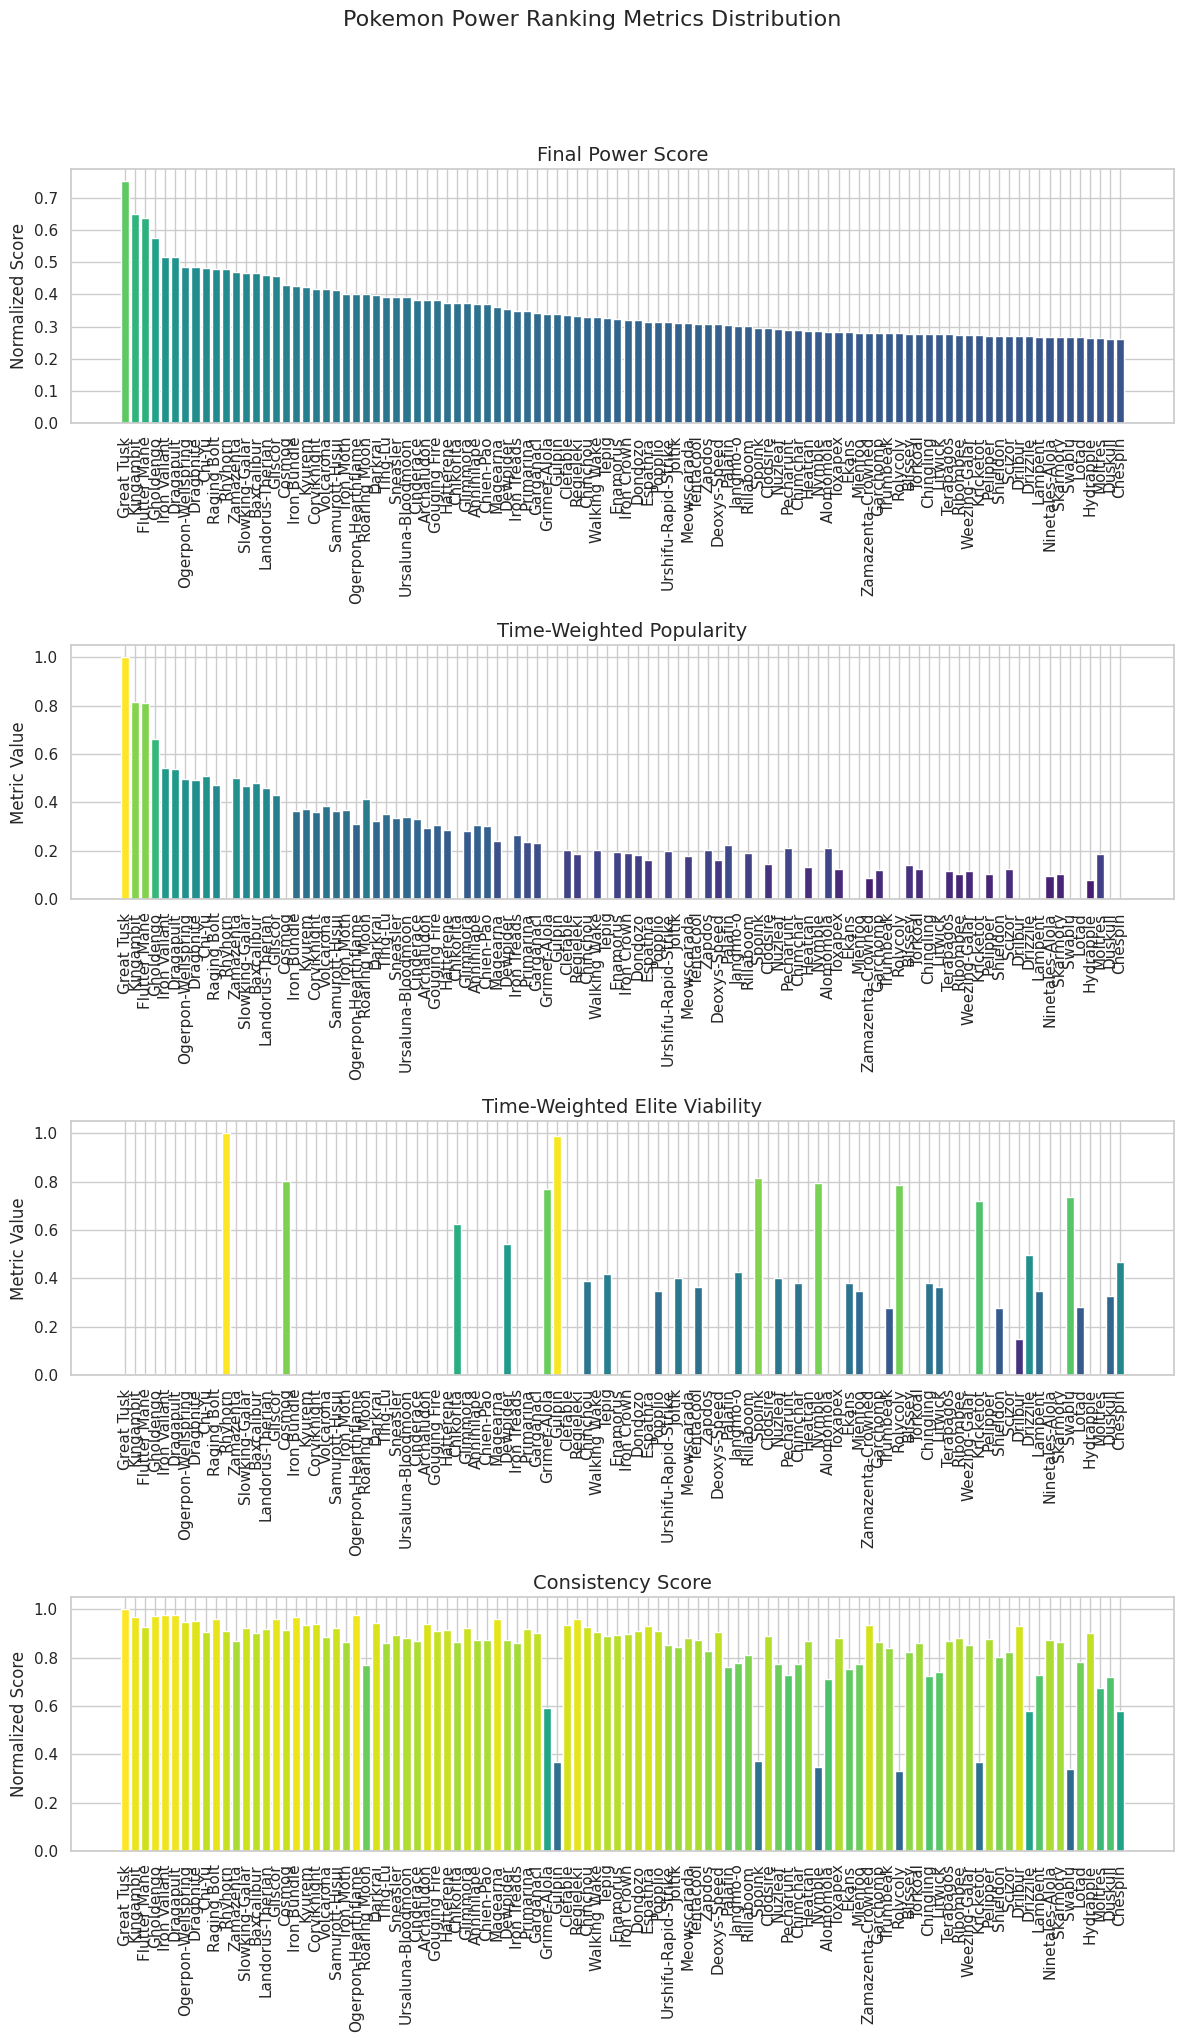

In [121]:
save_path="PAC-dataset/smogon_stats/gen9-ou_power_ranking.csv"
if not os.path.exists(save_path):
    df9=create_power_ranking(df, save_path=save_path)
else: df9=pd.read_csv(save_path)

visualize_rankings(df=df.iloc[:100, :])

In [ ]:
all_pokemons= df1.loc[:]

In [ ]:
import os
import matplotlib.pyplot as plt
from collections import defaultdict
import re

file_names= os.listdir('PAC-dataset/parsed-replays/gen9ou')


In [ ]:
yearly_data = defaultdict(lambda: defaultdict(int))

# Regular expression to extract the date and win/loss status
# It looks for a sequence of digits for the date, followed by either "WIN" or "LOSS"
pattern = re.compile(r"(\d{2}-\d{2}-(\d{4}))_(WIN|LOSS)\.json\.lz4")

# Process each filename
for filename in file_names:
    match = pattern.search(filename)
    if match:
        year = match.group(2)  # The year is the second captured group
        result = match.group(3) # The result (WIN/LOSS) is the third
        yearly_data[year][result] += 1

# Now, plot the data for each year
for year, results in yearly_data.items():
    labels = list(results.keys())
    counts = list(results.values())
    
    # Create the pie chart
    fig, ax = plt.subplots()
    ax.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#F44336'])
    ax.set_title(f"Win/Loss Distribution for {year}")
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    
    # Display the plot
    plt.show()
